## Loading necessary Libraries

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib
from flask import Flask, request, jsonify
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import numpy as np

## Loading The dataset

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

## Handling missing Values

In [3]:
df.isnull().sum()  # Identify missing values
df.fillna(method='ffill', inplace=True)  # Example: Forward fill

## Encoding

In [4]:
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

print(df.head())

   RowNumber  CustomerId  Surname  CreditScore  Geography  Gender  Age  \
0          1    15634602     1115          619          0       0   42   
1          2    15647311     1177          608          2       0   41   
2          3    15619304     2040          502          0       0   42   
3          4    15701354      289          699          0       0   39   
4          5    15737888     1822          850          2       0   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

# Exploratory Data Analysis

## Summary Of Statistics

In [5]:
print(df.describe())

         RowNumber    CustomerId       Surname   CreditScore     Geography  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07   1507.774200    650.528800      0.746300   
std     2886.89568  7.193619e+04    846.204311     96.653299      0.827529   
min        1.00000  1.556570e+07      0.000000    350.000000      0.000000   
25%     2500.75000  1.562853e+07    773.750000    584.000000      0.000000   
50%     5000.50000  1.569074e+07   1542.000000    652.000000      0.000000   
75%     7500.25000  1.575323e+07   2238.250000    718.000000      1.000000   
max    10000.00000  1.581569e+07   2931.000000    850.000000      2.000000   

             Gender           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean       0.545700     38.921800      5.012800   76485.889288       1.530200   
std        0.497932     10.487806      2.892174   6239

## Visualization

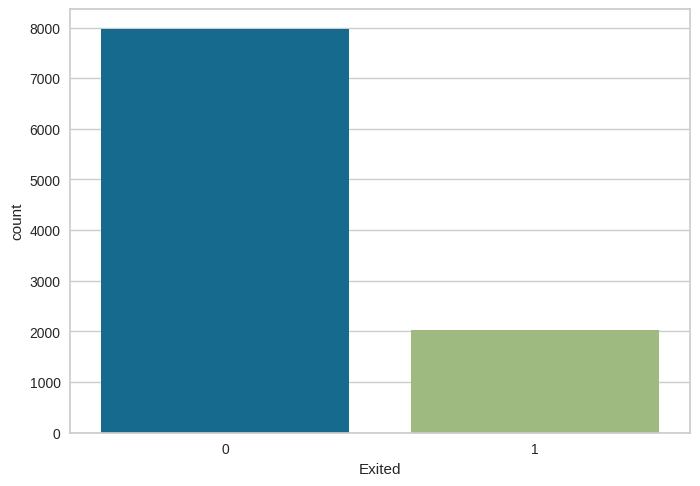

/home/faizan/anaconda3/envs/FEnv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


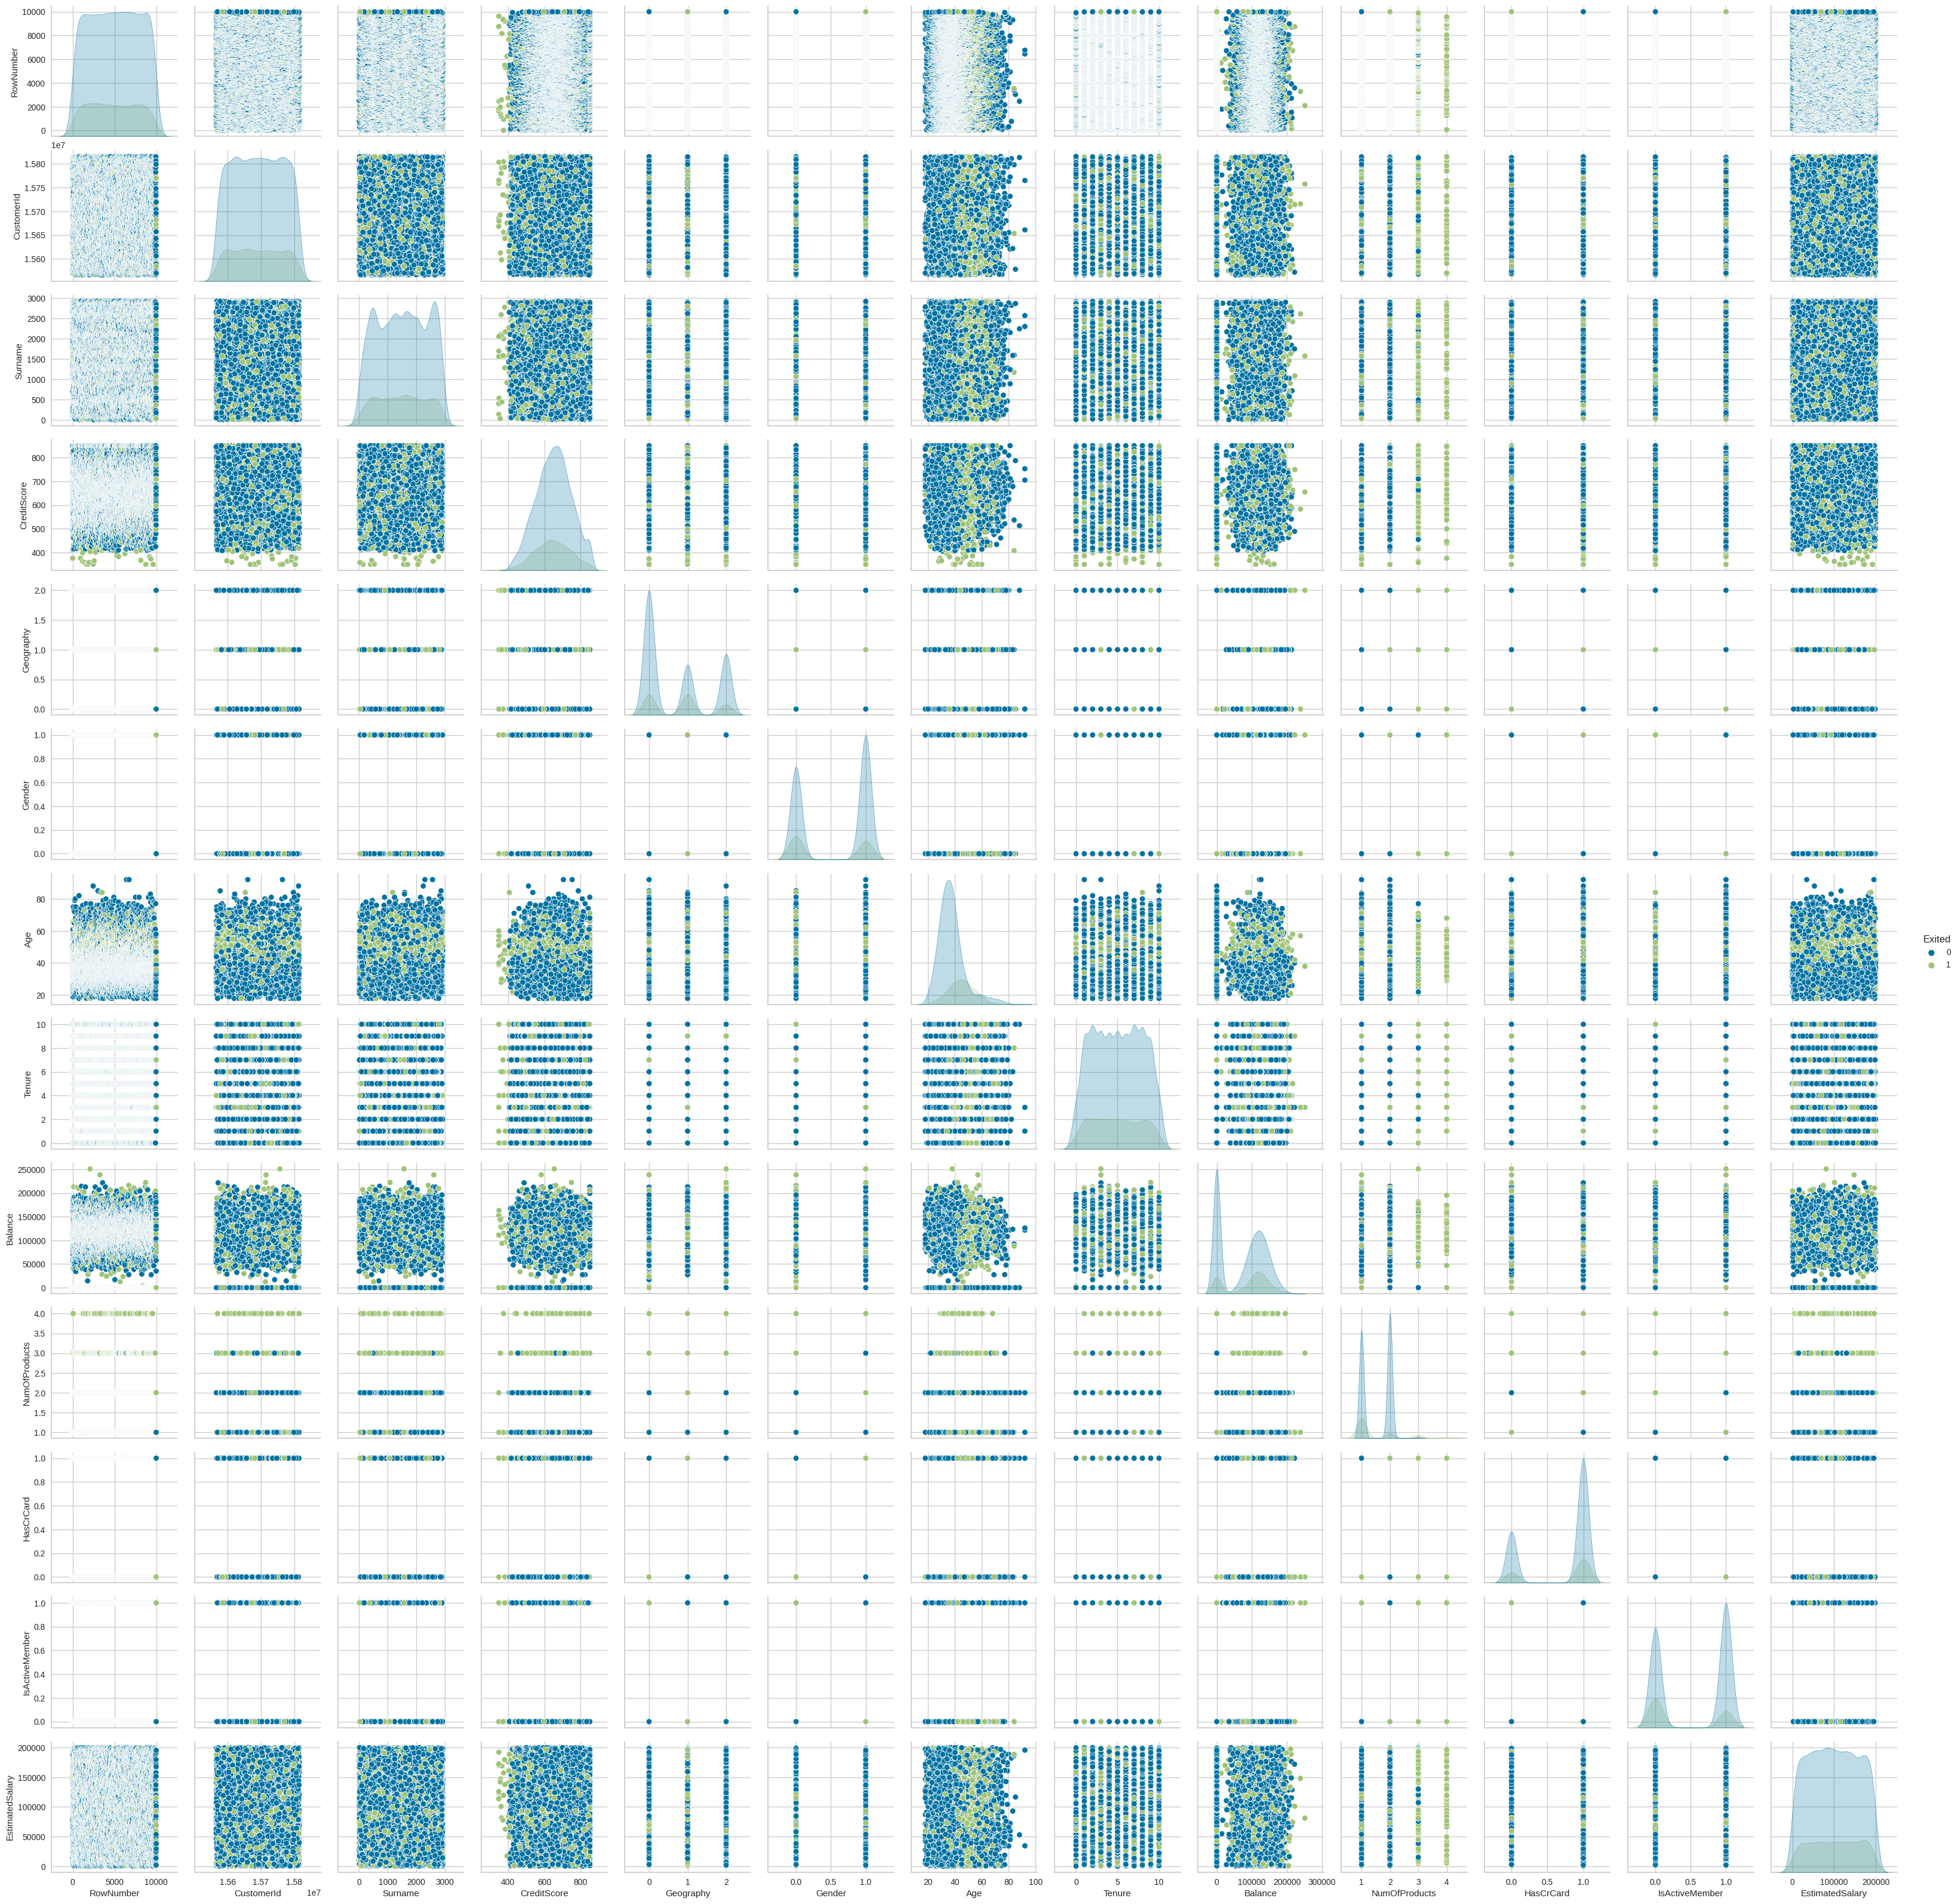

In [7]:
sns.countplot(x='Exited', data=df)
plt.show()

sns.pairplot(df, hue='Exited')
plt.show()

# Feature Engineering

## Feature Selection

In [10]:
X = df.drop('Exited', axis=1)
y = df['Exited']
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

            Feature         Score
8           Balance  7.151303e+06
12  EstimatedSalary  4.835088e+04
0         RowNumber  4.576382e+03
6               Age  2.300417e+03
2           Surname  5.561332e+02
1        CustomerId  1.287308e+02
11   IsActiveMember  1.181994e+02
3       CreditScore  1.054035e+02
5            Gender  5.153993e+01
4         Geography  1.185325e+01


## Feature Scaling

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting dataset into test and train sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Training The models

In [17]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print('Logistic Regression')
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('Random Forest')
print(classification_report(y_test, y_pred_rf))

Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.28       393

    accuracy                           0.82      2000
   macro avg       0.72      0.57      0.58      2000
weighted avg       0.78      0.82      0.77      2000

Random Forest
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.44      0.56       393

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.85      2000



## Confusion Matrix

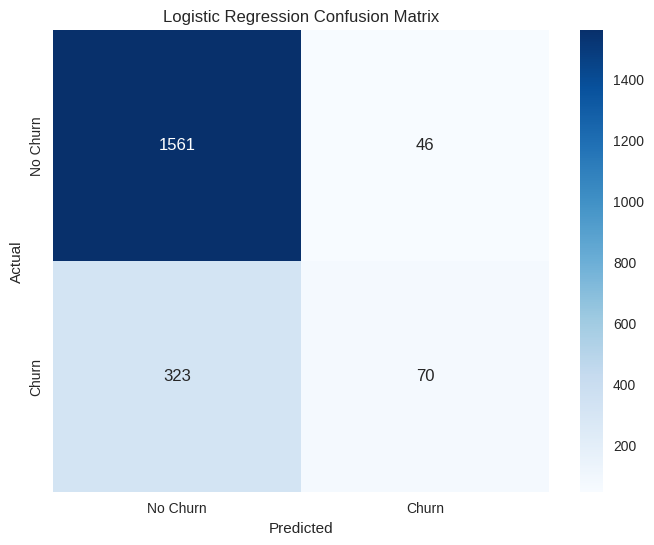

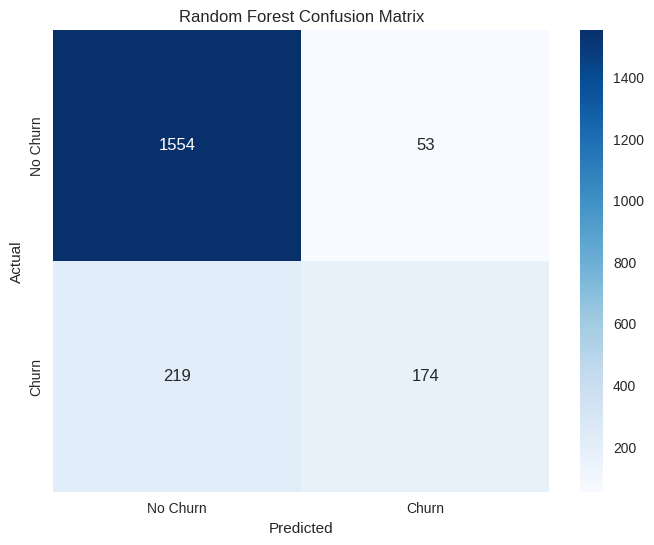

In [18]:
# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig("confusion_matrix_lr.png")
plt.show()

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.savefig("confusion_matrix_rf.png")
plt.show()

## ROC-CURVE

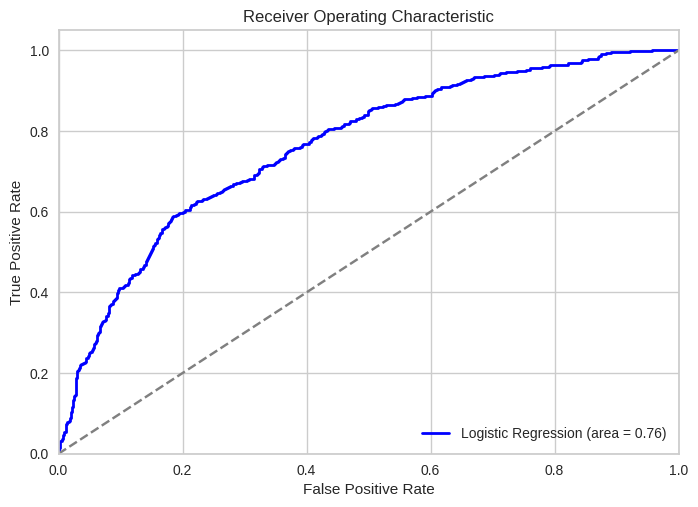

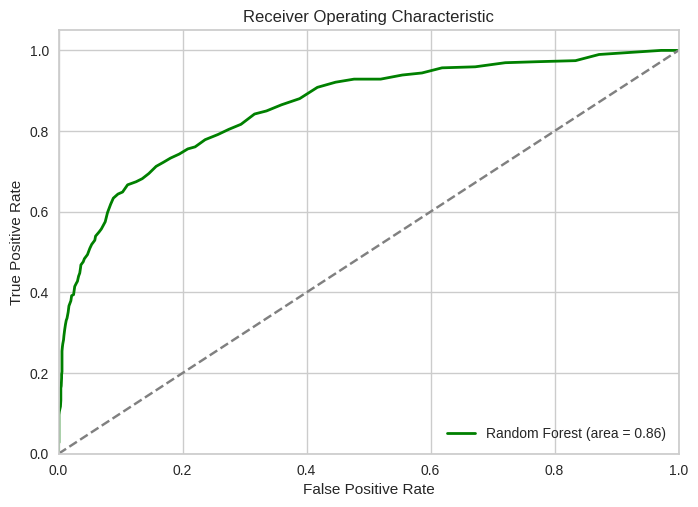

In [19]:
# Logistic Regression ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_curve_lr.png")
plt.show()

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_curve_rf.png")
plt.show()

# Hyperparameter Tunning

In [20]:
# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Logistic Regression Grid Search
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random Forest Grid Search
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

## Model Evaluation

### Best Hyperparameter

In [21]:
# Best hyperparameters for Logistic Regression
best_params_lr = grid_search_lr.best_params_
print("Best Hyperparameters for Logistic Regression: ", best_params_lr)

# Best hyperparameters for Random Forest
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest: ", best_params_rf)

Best Hyperparameters for Logistic Regression:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Hyperparameters for Random Forest:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


## Prediction

In [22]:
# Evaluate the best models on the test set
best_lr = grid_search_lr.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Predictions
y_pred_best_lr = best_lr.predict(X_test)
y_pred_best_rf = best_rf.predict(X_test)

## Classification Report

In [23]:
print("Classification Report for Best Logistic Regression Model")
print(classification_report(y_test, y_pred_best_lr))

print("Classification Report for Best Random Forest Model")
print(classification_report(y_test, y_pred_best_rf))

Classification Report for Best Logistic Regression Model
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1607
           1       0.60      0.18      0.27       393

    accuracy                           0.81      2000
   macro avg       0.71      0.57      0.58      2000
weighted avg       0.78      0.81      0.77      2000

Classification Report for Best Random Forest Model
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.78      0.46      0.58       393

    accuracy                           0.87      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



## Confusion matrix

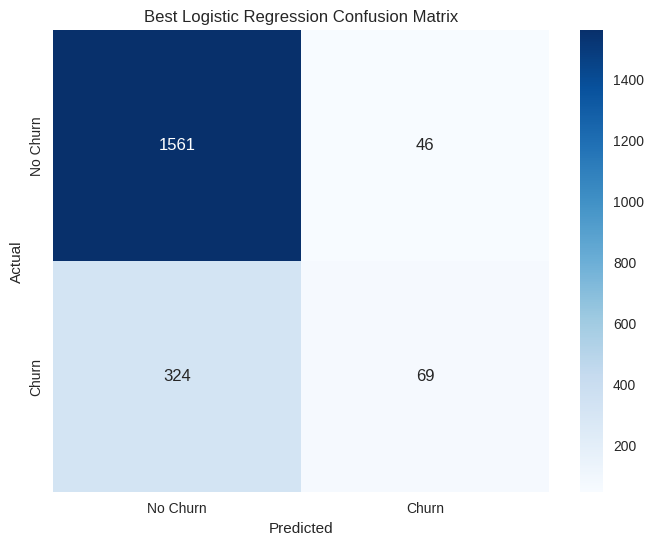

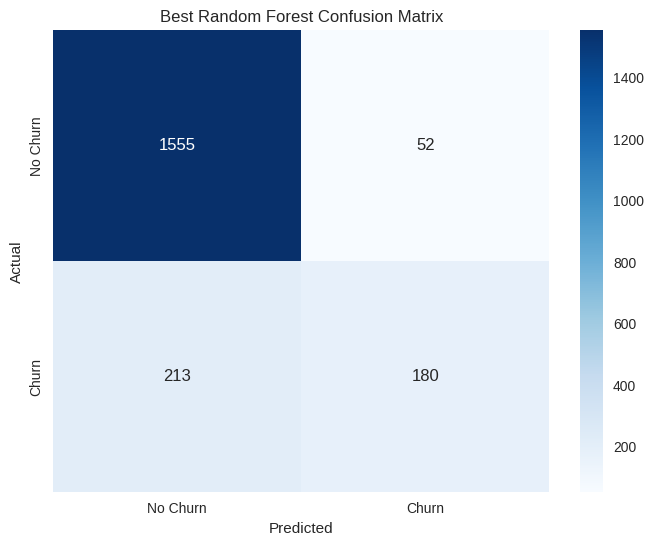

In [24]:
# Confusion Matrix for Logistic Regression
cm_best_lr = confusion_matrix(y_test, y_pred_best_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm_best_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Logistic Regression Confusion Matrix')
plt.show()

# Confusion Matrix for Random Forest
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Random Forest Confusion Matrix')
plt.show()

## Saving the model

In [26]:
joblib.dump(best_rf, 'customer_churn_model_rf.pkl')

['customer_churn_model_rf.pkl']

In [27]:
joblib.dump(best_lr, 'customer_churn_model_lr.pkl')

['customer_churn_model_lr.pkl']